In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time
plt.style.use('seaborn')
from imblearn.over_sampling import SMOTE
import pickle

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('file:///C:/Users/JChaotogo/Documents/DataSets/Churn.csv')
df['Churn'] = np.where(df.Churn=='Yes',1,0)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


# Clean the Data

There's not much missing data or special characters that would throw us off. But we should change the binary variables to 0 and 1s and expand the categorical variables by using dummies. For the data that has a third varible such as "No internet service" or "No Phone Service, the information is already captured by the 'Phone Service' and 'InternetService' columns. We could try to create a seperate variable for customers who have neither phone service and internetservice.

In [4]:
df['female'] = np.where(df.gender=='Female',1,0)
df['haspartner'] = np.where(df.Partner=='Yes',1,0)
df['hasdependents'] = np.where(df.Dependents=='Yes',1,0)
df['hasphoneservice'] = np.where(df.PhoneService =='Yes',1,0)
df['hasmultlines'] = np.where(df.MultipleLines=='Yes',1,0)
df['hasonlinesec'] = np.where(df.OnlineSecurity =='Yes',1,0)
df['hasonlinebackup'] = np.where(df.OnlineBackup =='Yes',1,0)
df['hasdeviceprotection'] = np.where(df.DeviceProtection=='Yes',1,0)
df['hastechsupport'] = np.where(df.TechSupport=='Yes',1,0)
df['hasstreamtv'] = np.where(df.StreamingTV=='Yes',1,0)
df['hasstreammovies'] = np.where(df.StreamingMovies=='Yes',1,0)
df['haspaperlessbill'] = np.where(df.PaperlessBilling=='Yes',1,0)
df.drop(columns=['customerID','gender','Partner','Dependents','MultipleLines','PhoneService','OnlineSecurity','OnlineBackup',
                 'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling'],inplace=True)

# Exploring the Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
SeniorCitizen          7043 non-null int64
tenure                 7043 non-null int64
InternetService        7043 non-null object
Contract               7043 non-null object
PaymentMethod          7043 non-null object
MonthlyCharges         7043 non-null float64
TotalCharges           7043 non-null object
Churn                  7043 non-null int32
female                 7043 non-null int32
haspartner             7043 non-null int32
hasdependents          7043 non-null int32
hasphoneservice        7043 non-null int32
hasmultlines           7043 non-null int32
hasonlinesec           7043 non-null int32
hasonlinebackup        7043 non-null int32
hasdeviceprotection    7043 non-null int32
hastechsupport         7043 non-null int32
hasstreamtv            7043 non-null int32
hasstreammovies        7043 non-null int32
haspaperlessbill       7043 non-null int32
dtypes: float64(1), int32(1

In [6]:
#TotalCharges should be a float but there must be some missing information. The problem seems to come from customers who have
#a tenure of 0 months. To solve this, I make the assumption that they will end up paying for 1 month of service, so I replace
#the empty TotalCharges field with the monthlycharges value.
df[df.TotalCharges==' ']
df[df.TotalCharges== ' '].TotalCharges= np.nan
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
df.TotalCharges = np.where(df.TotalCharges.isna(), df.MonthlyCharges, df.TotalCharges)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [7]:
df.head()

,SeniorCitizen,tenure,InternetService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,female,haspartner,hasdependents,hasphoneservice,hasmultlines,hasonlinesec,hasonlinebackup,hasdeviceprotection,hastechsupport,hasstreamtv,hasstreammovies,haspaperlessbill
0,0,1,DSL,Month-to-month,Electronic check,29.85,29.85,0,1,1,0,0,0,0,1,0,0,0,0,1
1,0,34,DSL,One year,Mailed check,56.95,1889.50,0,0,0,0,1,0,1,0,1,0,0,0,0
2,0,2,DSL,Month-to-month,Mailed check,53.85,108.15,1,0,0,0,1,0,1,1,0,0,0,0,1
3,0,45,DSL,One year,Bank transfer (automatic),42.30,1840.75,0,0,0,0,0,0,1,0,1,1,0,0,0
4,0,2,Fiber optic,Month-to-month,Electronic check,70.70,151.65,1,1,0,0,1,0,0,0,0,0,0,0,1


In [8]:
print(round(df[df.Churn==1].shape[0]/df.shape[0]*100,1), '% of Customers Churn')

26.5 % of Customers Churn


In [9]:
#Here I create a function to quickly iterate through all pie charts for all the categorical variables.
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6]))
def pieplots(outer, label1, label2):
    size = .6
    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(3)*4)
    inner_colors = cmap(np.array([1, 2, 5, 6]))
    fig, ax = plt.subplots(figsize=(8,8))
    
    ax.pie(outer.sum(axis=1), radius=.8, wedgeprops=dict(width=size, edgecolor='w'), labels=[label1,label2], 
               autopct='%1.1f%%', pctdistance=.9, labeldistance=1.3, colors=outer_colors)

    ax.pie(outer.flatten(), radius=.6, wedgeprops=dict(width=size, edgecolor='w'), 
            labels = ['',str(round(outer[0,1]/(outer[0,1]+outer[0,0])*100,1)) +'%\nChurn','', 
                      str(round(outer[1,1]/(outer[1,1]+outer[1,0])*100,1)) +'%\nChurn'], 
            colors=inner_colors, labeldistance=.5)
    
    ax.set(aspect='equal', title=label1 + ' Churn Rate')

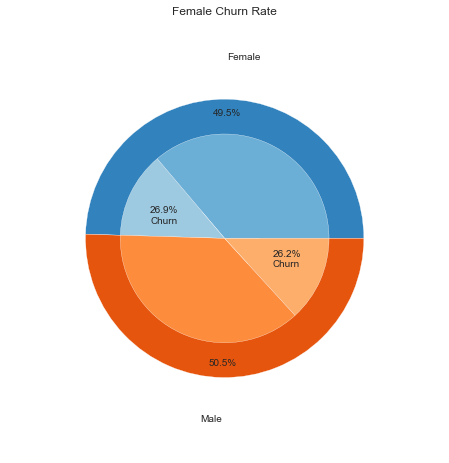

In [10]:
female = df[df.female==1]['Churn'].value_counts().values.tolist()
male = df[df.female==0]['Churn'].value_counts().values.tolist()
genderv = np.array([female, male])
pieplots(genderv, 'Female', 'Male')

The gender populations are equal and gender has no effect on churn rate.

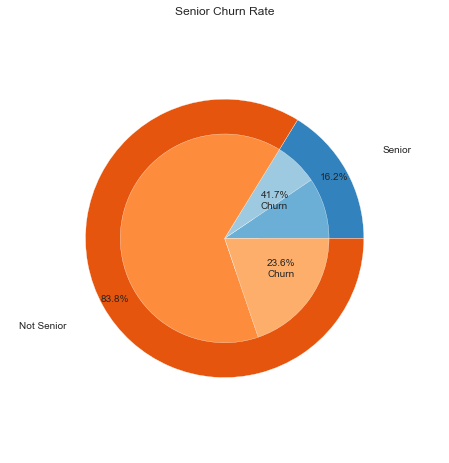

In [11]:
seniorv = np.array([df[df.SeniorCitizen==1]['Churn'].value_counts().values.tolist(),
                   df[df.SeniorCitizen==0]['Churn'].value_counts().values.tolist()])

pieplots(seniorv, 'Senior','Not Senior')

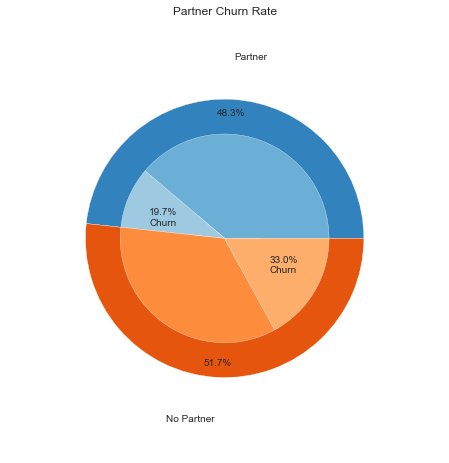

In [12]:
partnerv = np.array([df[df.haspartner==1]['Churn'].value_counts().values.tolist(),
                   df[df.haspartner==0]['Churn'].value_counts().values.tolist()])

pieplots(partnerv, 'Partner','No Partner')

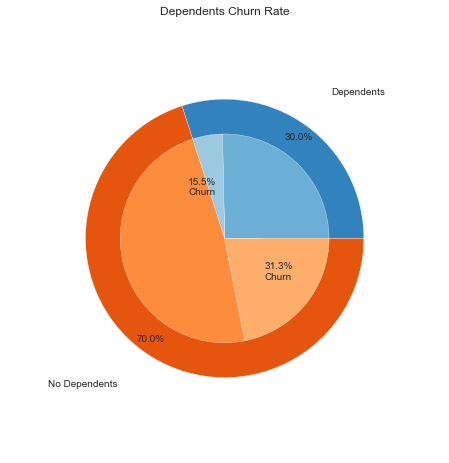

In [13]:
dependentsv = np.array([df[df.hasdependents==1]['Churn'].value_counts().values.tolist(),
                   df[df.hasdependents==0]['Churn'].value_counts().values.tolist()])

pieplots(dependentsv, 'Dependents','No Dependents')

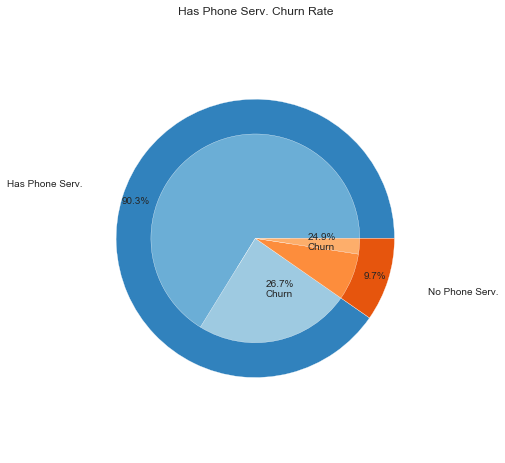

In [14]:
phoneserv = np.array([df[df.hasphoneservice==1]['Churn'].value_counts().values.tolist(),
                   df[df.hasphoneservice==0]['Churn'].value_counts().values.tolist()])
pieplots(phoneserv, 'Has Phone Serv.', 'No Phone Serv.')

In [15]:
def pieplots3(outer, label1, label2,label3):
    size = .6
    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(3)*4)
    inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))
    fig, ax = plt.subplots(figsize=(8,8))
    
    ax.pie(outer.sum(axis=1), radius=.8, wedgeprops=dict(width=size, edgecolor='w'), labels=[label1,label2,label3], 
               autopct='%1.1f%%', pctdistance=.9, labeldistance=1.2, colors=outer_colors)

    ax.pie(outer.flatten(), radius=.6, wedgeprops=dict(width=size, edgecolor='w'), 
            labels = ['',str(round(outer[0,1]/(outer[0,1]+outer[0,0])*100,1)) +'%\nChurn','', 
                      str(round(outer[1,1]/(outer[1,1]+outer[1,0])*100,1)) +'%\nChurn','',
                      str(round(outer[2,1]/(outer[2,1]+outer[2,0])*100,1)) +'%\nChurn'],
            colors=inner_colors, labeldistance=.71)
    
    ax.set(aspect='equal', title=label1 + ' Churn Rate')

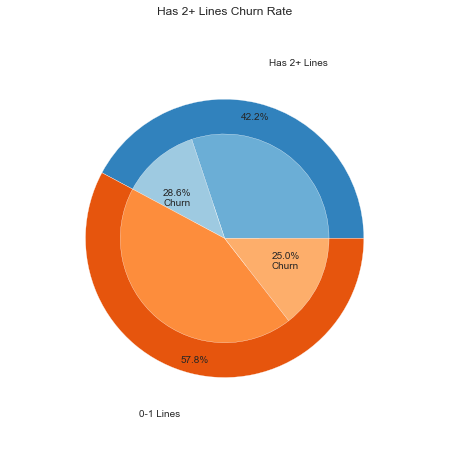

In [16]:
multlines = np.array([df[df.hasmultlines==1]['Churn'].value_counts().values.tolist(),
                   df[df.hasmultlines==0]['Churn'].value_counts().values.tolist()])
pieplots(multlines, 'Has 2+ Lines', '0-1 Lines')

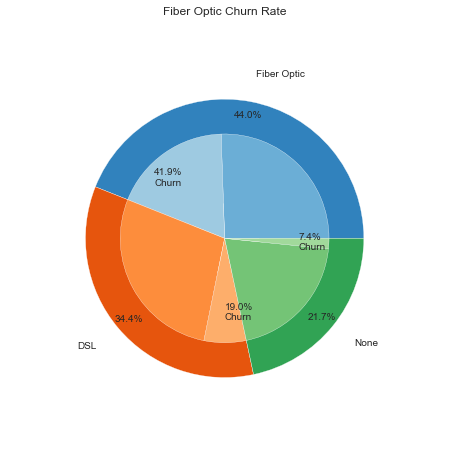

In [17]:
internetserv = np.array([df[df.InternetService=='Fiber optic']['Churn'].value_counts().values.tolist(),
                   df[df.InternetService=='DSL']['Churn'].value_counts().values.tolist(),
                   df[df.InternetService=='No']['Churn'].value_counts().values.tolist()])
pieplots3(internetserv, 'Fiber Optic', 'DSL', 'None')

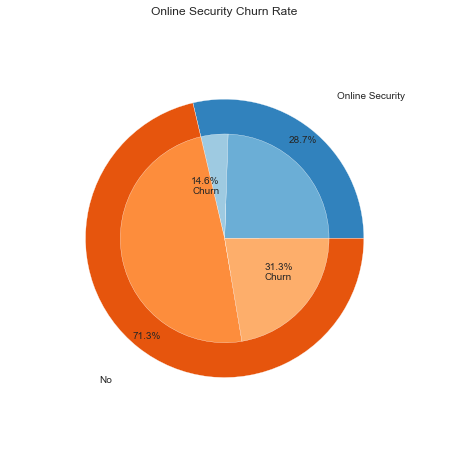

In [18]:
onlinesec = np.array([df[df.hasonlinesec==1]['Churn'].value_counts().values.tolist(),
                   df[df.hasonlinesec==0]['Churn'].value_counts().values.tolist()])
pieplots(onlinesec, 'Online Security', 'No')

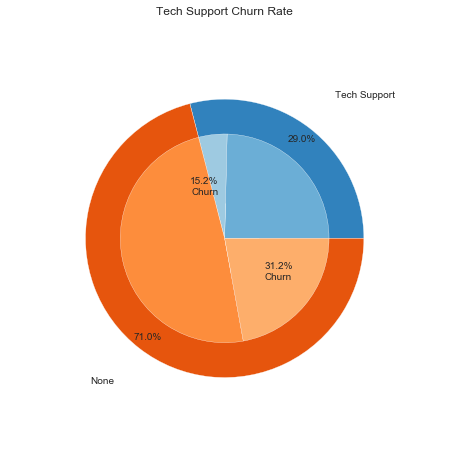

In [19]:
techsupp = np.array([df[df.hastechsupport==1]['Churn'].value_counts().values.tolist(),
                   df[df.hastechsupport==0]['Churn'].value_counts().values.tolist()])
pieplots(techsupp, 'Tech Support', 'None')

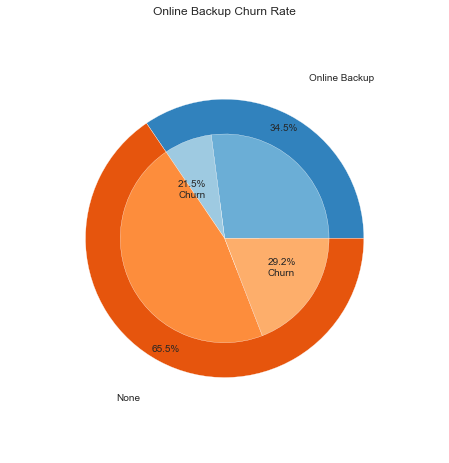

In [20]:
backup = np.array([df[df.hasonlinebackup==1]['Churn'].value_counts().values.tolist(),
                   df[df.hasonlinebackup==0]['Churn'].value_counts().values.tolist()])
pieplots(backup, 'Online Backup', 'None')

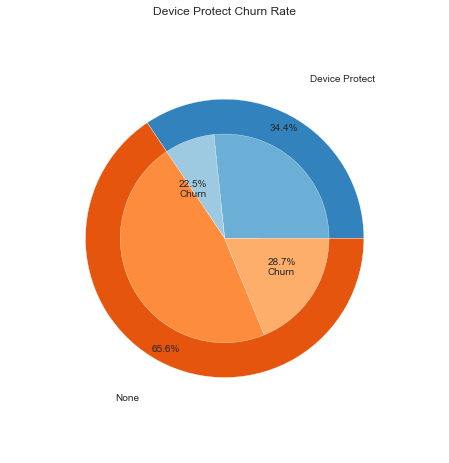

In [21]:
devicep = np.array([df[df.hasdeviceprotection==1]['Churn'].value_counts().values.tolist(),
                   df[df.hasdeviceprotection==0]['Churn'].value_counts().values.tolist()])
pieplots(devicep, 'Device Protect', 'None')

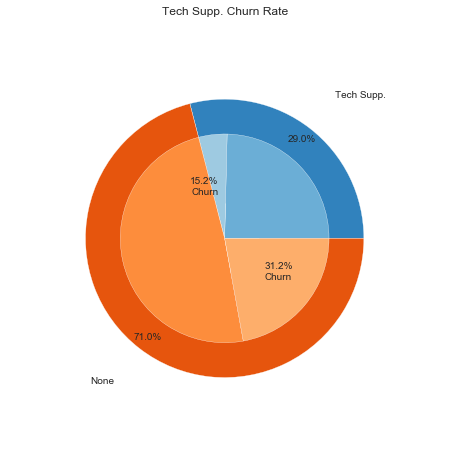

In [22]:
techs = np.array([df[df.hastechsupport==1]['Churn'].value_counts().values.tolist(),
                   df[df.hastechsupport==0]['Churn'].value_counts().values.tolist()])
pieplots(techs, 'Tech Supp.', 'None')

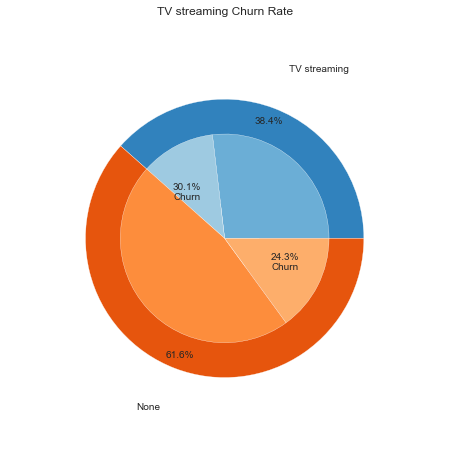

In [23]:
streamtv = np.array([df[df.hasstreamtv==1]['Churn'].value_counts().values.tolist(),
                   df[df.hasstreamtv==0]['Churn'].value_counts().values.tolist()])
pieplots(streamtv, 'TV streaming', 'None')

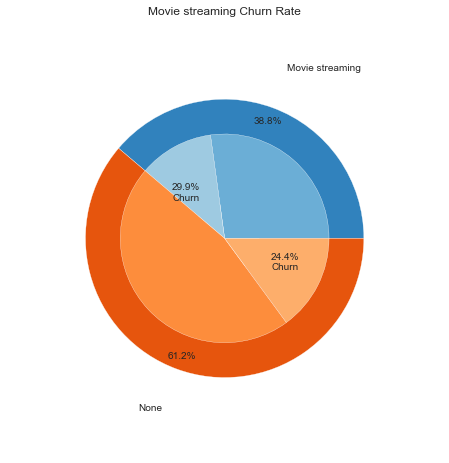

In [24]:
streamm = np.array([df[df.hasstreammovies==1]['Churn'].value_counts().values.tolist(),
                   df[df.hasstreammovies==0]['Churn'].value_counts().values.tolist()])
pieplots(streamm, 'Movie streaming', 'None')

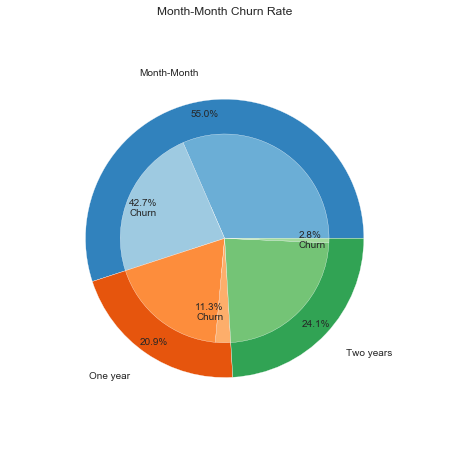

In [25]:
contract = np.array([df[df.Contract=='Month-to-month']['Churn'].value_counts().values.tolist(),
                   df[df.Contract=='One year']['Churn'].value_counts().values.tolist(),
                   df[df.Contract=='Two year']['Churn'].value_counts().values.tolist()])
pieplots3(contract, 'Month-Month', 'One year', 'Two years')

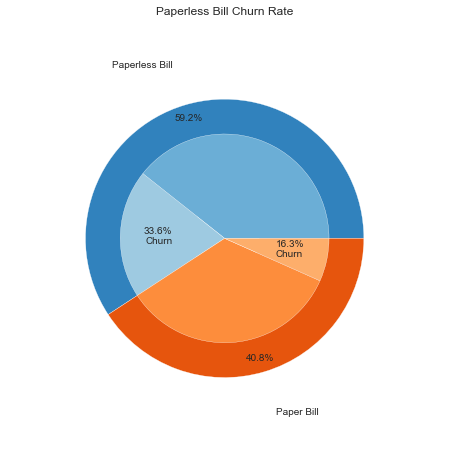

In [26]:
paperless = np.array([df[df.haspaperlessbill==1]['Churn'].value_counts().values.tolist(),
                   df[df.haspaperlessbill==0]['Churn'].value_counts().values.tolist()])
pieplots(paperless, 'Paperless Bill', 'Paper Bill')

[Text(0.5,1,'Payment Method Churn Rate'), None]

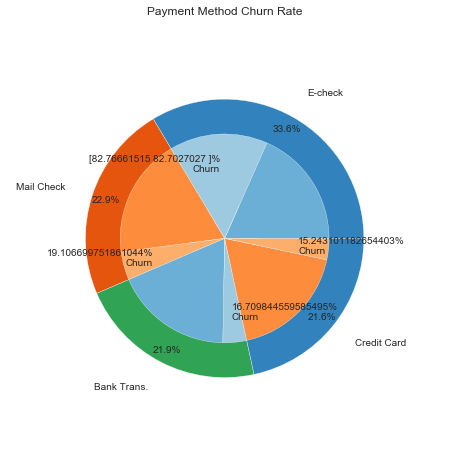

In [27]:
pay = np.array([df[df.PaymentMethod=='Electronic check']['Churn'].value_counts().values.tolist(),
                   df[df.PaymentMethod=='Mailed check']['Churn'].value_counts().values.tolist(),
                   df[df.PaymentMethod=='Bank transfer (automatic)']['Churn'].value_counts().values.tolist(),
                   df[df.PaymentMethod=='Credit card (automatic)']['Churn'].value_counts().values.tolist()])



fig, ax = plt.subplots(figsize=(8,8))
size=.6
ax.pie(pay.sum(axis=1), radius=.8, wedgeprops=dict(width=size, edgecolor='w'), labels=['E-check','Mail Check',
                'Bank Trans.','Credit Card'], autopct='%1.1f%%', pctdistance=.9, labeldistance=1.2, colors=outer_colors)

ax.pie(pay.flatten(), radius=.6, wedgeprops=dict(width=size, edgecolor='w'), 
            labels = ['',str(pay[0,1]/([0,1]+pay[0,0])*100) +'%\nChurn','', 
                      str(pay[1,1]/(pay[1,1]+pay[1,0])*100) +'%\nChurn','',
                      str(pay[2,1]/(pay[2,1]+pay[2,0])*100) +'%\nChurn','',
                      str(pay[3,1]/(pay[3,1]+pay[3,0])*100) +'%\nChurn'],
            colors=inner_colors, labeldistance=.71)    
ax.set(aspect='equal', title='Payment Method' + ' Churn Rate')

There is an enormous disparity in the tenure times between the churn group and non-churn group. The majority of churn customers leave the company after only a few months. The longest recorded tenure is 72 months and they mostly consist of non-churn customers.

Text(0.5,1,'Relationship between Payment Method and Churn')

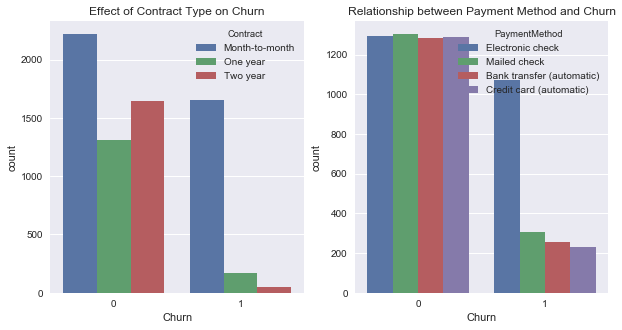

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(df.Churn, hue=df.Contract)
plt.title('Effect of Contract Type on Churn')
plt.subplot(1,2,2)
sns.countplot(df.Churn, hue=df.PaymentMethod)
plt.title('Relationship between Payment Method and Churn')

Month-month plans are more popular than the contract options for both demographics. However customers who churn are much more likely to be have a monthly plan. Looking at the payment methods graph, the four methods of payment are pretty evenly utlized by the customers who stay with the company. The group of customers who churn disproportionately choose to pay with electronic check. Unsurprisingly, the two automatic payment options are least frequently used. Below, we'll look at how the relationship between continuous variables and churn.

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


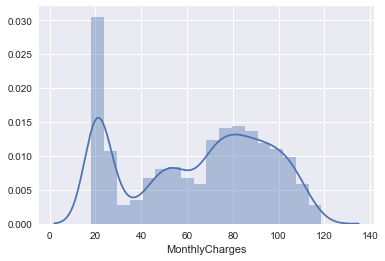

In [29]:
sns.distplot(df.MonthlyCharges)

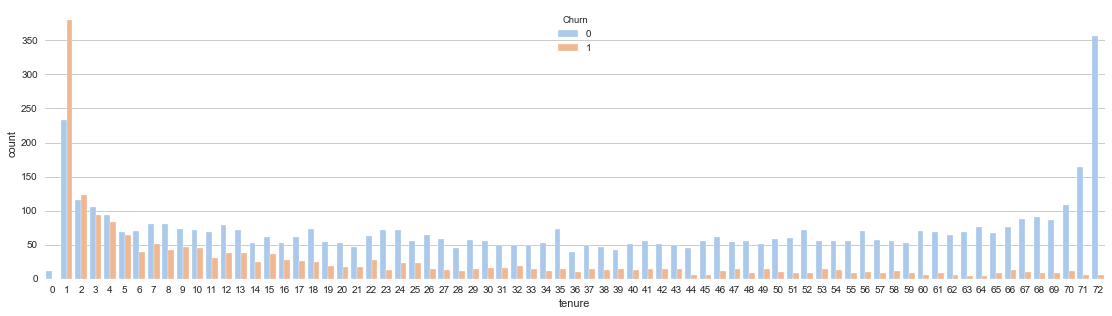

In [30]:
sns.set_style("whitegrid")
plt.figure(figsize=(19,5))
sns.countplot(df['tenure'], hue=df.Churn, palette='pastel')

There is an enormous disparity in the tenure times between the churn group and non-churn group. The majority of churn customers leave the company after only a few months. The longest recorded tenure is 72 months and they mostly consist of non-churn customers. We also expect price to have a significant impact on churn rate of customers, however, we're going to exclude TotalCharges from the analysis because it is directly related to tenure and wouldn't help us visualize the price effect on customer churn.

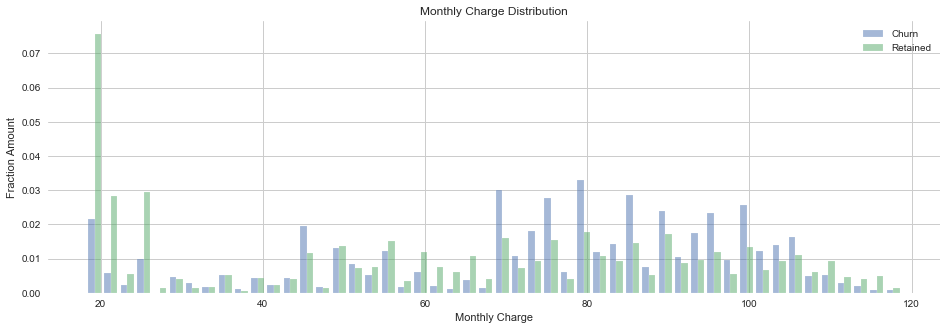

In [31]:
churny = df[df.Churn==1]
churnn = df[df.Churn==0]
plt.figure(figsize=(16,5))
plt.hist([churny['MonthlyCharges'], churnn['MonthlyCharges']], alpha=.5, bins=50, density=True)
plt.legend(['Churn', 'Retained'])
plt.ylabel('Fraction Amount')
plt.xlabel('Monthly Charge')
plt.title('Monthly Charge Distribution')
plt.show()

# Feature Engineering

We're going to choose churn as the target feature. The 3 continuous features are tenure, monthly charge, and total charge, the other features we will get from the various categorical variables.

In [32]:
dummies = pd.get_dummies(df[['Contract', 'PaymentMethod','InternetService']])
df.drop(columns=['InternetService','Contract','PaymentMethod'], inplace=True)

In [33]:
features = pd.concat([dummies, df], axis=1, join='outer')


In [34]:
features.head()

,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,...,hasdependents,hasphoneservice,hasmultlines,hasonlinesec,hasonlinebackup,hasdeviceprotection,hastechsupport,hasstreamtv,hasstreammovies,haspaperlessbill
0,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,1,0,0,0,0,1,1,0,0,...,0,1,0,1,0,1,0,0,0,0
2,1,0,0,0,0,0,1,1,0,0,...,0,1,0,1,1,0,0,0,0,1
3,0,1,0,1,0,0,0,1,0,0,...,0,0,0,1,0,1,1,0,0,0
4,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [35]:
features.dtypes

Contract_Month-to-month                      uint8
Contract_One year                            uint8
Contract_Two year                            uint8
PaymentMethod_Bank transfer (automatic)      uint8
PaymentMethod_Credit card (automatic)        uint8
PaymentMethod_Electronic check               uint8
PaymentMethod_Mailed check                   uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
SeniorCitizen                                int64
tenure                                       int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int32
female                                       int32
haspartner                                   int32
hasdependents                                int32
hasphoneservice                              int32
hasmultlines                   

# Creating the Models
Because this is a classification model we're going to try Logistic Regression, RandomForestClassifier, and........

In [36]:
#Create the training and test sets.
X=features.drop(columns='Churn')
Y=features['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=.3, random_state=0)

In [37]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr.score(X_test,y_test)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8007572172266919

In [38]:
#evaluate the log model
predy = lgr.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predy, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predy))

Cross-Tab

 Churn     0    1
row_0           
0      1394  255
1       166  298

Classification Report

               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1560
           1       0.64      0.54      0.59       553

   micro avg       0.80      0.80      0.80      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113



Our first log model gave us a precision of 80% but because of the large class imbalance, the f1-score for the correctly predicting churn customers was rather low at 59%. We can attempt to get a better score by tuning the parameters a bit using GridSearchCV.

In [39]:
start=time.time()
parameters = {'penalty':['l1','l2'], 'C':[.0000001, .00001,.001,.01,1,100,10000,1000000], 'class_weight':['balanced', None]}
grid = GridSearchCV(lgr, parameters, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(time.time()-start)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 0.01, 'class_weight': None, 'penalty': 'l2'}
3.368957757949829


C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
#Using the parameters obtained
lgr = LogisticRegression(penalty='l2', C=.01)
lgr.fit(X_train, y_train)
print(lgr.score(X_train, y_train))
print(lgr.score(X_test, y_test))
predy = lgr.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predy, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predy))

0.808316430020284
0.8012304779933743
Cross-Tab

 Churn     0    1
row_0           
0      1411  271
1       149  282

Classification Report

               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1560
           1       0.65      0.51      0.57       553

   micro avg       0.80      0.80      0.80      2113
   macro avg       0.75      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113



C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [41]:
#Lets try Random Forest Classifiers
start=time.time()
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train,y_train)
print(rfc.score(X_train,y_train))
print(rfc.score(X_test,y_test))
predrfc = rfc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predrfc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predrfc))
print(time.time()-start)
#Our Random Forest Classifier horribly overfit, maybe changing the parameters will help to fix that.

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9793103448275862
0.7875059157595835
Cross-Tab

 Churn     0    1
row_0           
0      1405  294
1       155  259

Classification Report

               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1560
           1       0.63      0.47      0.54       553

   micro avg       0.79      0.79      0.79      2113
   macro avg       0.73      0.68      0.70      2113
weighted avg       0.77      0.79      0.78      2113

0.46269774436950684


In [42]:
feature_importances = pd.DataFrame(rfc.feature_importances_, index=X_train.columns, 
        columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
TotalCharges,0.198892
MonthlyCharges,0.172246
tenure,0.156832
Contract_Month-to-month,0.057846
InternetService_Fiber optic,0.036082
PaymentMethod_Electronic check,0.031920
female,0.027743
haspaperlessbill,0.023948
SeniorCitizen,0.021726
haspartner,0.021719


In [43]:
start=time.time()
parameters = {'n_estimators':[900,1000], 'max_depth':[6,7]}
grid = GridSearchCV(rfc, parameters, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(time.time()-start)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 6, 'n_estimators': 1000}
18.197009086608887


In [44]:
start=time.time()
rfc = RandomForestClassifier(n_jobs=-1, max_depth=7, n_estimators=900)
rfc.fit(X_train,y_train)
print(rfc.score(X_train,y_train))
print(rfc.score(X_test,y_test))
predrfc = rfc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predrfc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predrfc))
print(time.time()-start)

0.8261663286004057
0.804070042593469
Cross-Tab

 Churn     0    1
row_0           
0      1423  277
1       137  276

Classification Report

               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1560
           1       0.67      0.50      0.57       553

   micro avg       0.80      0.80      0.80      2113
   macro avg       0.75      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113

2.871859073638916


In [45]:
#cross_val_score(rfc, X, Y, cv=10)

# First Run Analysis
The classifiers we trained are good at predicting negative churn at a tremendously recall rate. However, the recall rate for predicting positive churn is extremely low. This is most likely caused by the class imbalance which incentivizes the model to predict negative churn more often. Originally, my thought was that 25% postive and 75% negative data would be sufficient as the positive class was still sufficiently large. But based on the recall scores, we can see that the model has a high false negative rate. In the next steps, I will try to improve the sensitivity of the model by artificially balancing the classes. When better scores are obtained, I'll try to add more models and tune them to be more specific and sensitive.

# Applying SMOTE

In [46]:
#Use SMOTE to oversample the minority class.
sm = SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

# Logistic Regression (Lasso and Ridge)

In [47]:
lgr = LogisticRegression(penalty='l2', C=10000)
lgr.fit(X_train_smote, y_train_smote)
print(lgr.score(X_train_smote, y_train_smote))
print(lgr.score(X_test, y_test))
predy = lgr.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predy, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predy))

0.7815439955727725
0.7520113582584004
Cross-Tab

 Churn     0    1
row_0           
0      1157  121
1       403  432

Classification Report

               precision    recall  f1-score   support

           0       0.91      0.74      0.82      1560
           1       0.52      0.78      0.62       553

   micro avg       0.75      0.75      0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113



C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [48]:
#Parameter optimization with l2 penalty (Ridge Regression)
start=time.time()
parameters = {'penalty':['l2'], 'C':[.0000001, .00001,.001,.01,1,100,10000,1000000], 'class_weight':['balanced', None]}
grid = GridSearchCV(lgr, parameters, n_jobs=-1)
grid.fit(X_test, y_test)
print(grid.best_params_)
print(time.time()-start)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 1, 'class_weight': None, 'penalty': 'l2'}
0.4186241626739502


C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [49]:
#Try the model with l1 penalty (Lasso)
lgr = LogisticRegression(penalty='l1', C=100)
lgr.fit(X_train_smote, y_train_smote)
print(lgr.score(X_train_smote, y_train_smote))
print(lgr.score(X_test, y_test))
predy = lgr.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predy, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predy))

0.7827891532927505
0.751538097491718
Cross-Tab

 Churn     0    1
row_0           
0      1152  117
1       408  436

Classification Report

               precision    recall  f1-score   support

           0       0.91      0.74      0.81      1560
           1       0.52      0.79      0.62       553

   micro avg       0.75      0.75      0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.81      0.75      0.76      2113



C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [50]:
#Parameter optimation for Lasso log regressor.
start=time.time()
parameters = {'penalty':['l1'], 'C':[.0000001, .00001,.001,.01,1,100,10000,1000000], 'class_weight':['balanced', None]}
grid = GridSearchCV(lgr, parameters, n_jobs=-1)
grid.fit(X_test, y_test)
print(grid.best_params_)
print(time.time()-start)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 10000, 'class_weight': None, 'penalty': 'l1'}
5.834857702255249


C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Random Forest Classifier

In [51]:
#Try RFC
start=time.time()
rfc = RandomForestClassifier(n_jobs=-1, max_depth=7, n_estimators=900)
rfc.fit(X_train_smote,y_train_smote)
print(rfc.score(X_train_smote,y_train_smote))
print(rfc.score(X_test,y_test))
predrfc = rfc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predrfc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predrfc))
print(time.time()-start)

0.862202545655783
0.780407004259347
Cross-Tab

 Churn     0    1
row_0           
0      1263  167
1       297  386

Classification Report

               precision    recall  f1-score   support

           0       0.88      0.81      0.84      1560
           1       0.57      0.70      0.62       553

   micro avg       0.78      0.78      0.78      2113
   macro avg       0.72      0.75      0.73      2113
weighted avg       0.80      0.78      0.79      2113

3.79591965675354


In [52]:
#Optimizing parameters for Random Forest Classifier
start=time.time()
parameters = {'n_estimators':[600], 'max_depth':[9],'max_features':[.7,.5,.3]}
grid = GridSearchCV(rfc, parameters, n_jobs=-1)
grid.fit(X_train_smote, y_train_smote)
print(grid.best_params_)
print(time.time()-start)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 9, 'max_features': 0.3, 'n_estimators': 600}
28.310275077819824


In [53]:
start=time.time()
rfc = RandomForestClassifier(n_jobs=-1, max_depth=9, n_estimators=600, max_features=.3)
rfc.fit(X_train_smote,y_train_smote)
print(rfc.score(X_train_smote,y_train_smote))
print(rfc.score(X_test,y_test))
predrfc = rfc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predrfc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predrfc))
print(cross_val_score(rfc, X, Y, n_jobs=-1, cv=10))
print(time.time()-start)

0.8919479800774764
0.7856128726928537
Cross-Tab

 Churn     0    1
row_0           
0      1307  200
1       253  353

Classification Report

               precision    recall  f1-score   support

           0       0.87      0.84      0.85      1560
           1       0.58      0.64      0.61       553

   micro avg       0.79      0.79      0.79      2113
   macro avg       0.72      0.74      0.73      2113
weighted avg       0.79      0.79      0.79      2113

[0.8070922  0.8141844  0.79858156 0.80992908 0.78693182 0.77414773
 0.83238636 0.79545455 0.79545455 0.81223329]
21.46548295021057


In [54]:
#Pickle the classifier
save_classifier = open('rfctelco.pickle','wb')
pickle.dump(rfc, save_classifier)
save_classifier.close()

In [55]:
#load the classifier
classifier_f = open('rfctelco.pickle','rb')
rfctelco = pickle.load(classifier_f)
classifier_f.close()

In [56]:
predrfctelco = rfctelco.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predrfctelco, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predrfctelco))

Cross-Tab

 Churn     0    1
row_0           
0      1307  200
1       253  353

Classification Report

               precision    recall  f1-score   support

           0       0.87      0.84      0.85      1560
           1       0.58      0.64      0.61       553

   micro avg       0.79      0.79      0.79      2113
   macro avg       0.72      0.74      0.73      2113
weighted avg       0.79      0.79      0.79      2113



# Gradient Boosting Classifier

In [58]:
#Searching for better parameters
start=time.time()
parameters = {'n_estimators':[600], 'max_depth':[7,9,11],'max_features':[.7,.5,.3], 'loss':['deviance','exponential']}
grid = GridSearchCV(gbc, parameters, n_jobs=-1)
grid.fit(X_train_smote, y_train_smote)
print(grid.best_params_)
print(time.time()-start)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'loss': 'exponential', 'max_depth': 11, 'max_features': 0.3, 'n_estimators': 600}
336.2790114879608


In [92]:
#Lets try to GBC one more time with different parameters
start=time.time()
params = {'n_estimators': 600,'max_depth': 3,'loss': 'deviance', 'max_features':1}
gbc = GradientBoostingClassifier(**params)
gbc.fit(X_train_smote,y_train_smote)
print(gbc.score(X_train_smote,y_train_smote))
print(gbc.score(X_test,y_test))
predgbc = gbc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predgbc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predgbc))
print(time.time()-start)

0.8825401217487548
0.7936583057264552
Cross-Tab

 Churn     0    1
row_0           
0      1362  238
1       198  315

Classification Report

               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1560
           1       0.61      0.57      0.59       553

   micro avg       0.79      0.79      0.79      2113
   macro avg       0.73      0.72      0.73      2113
weighted avg       0.79      0.79      0.79      2113

2.0023515224456787


In [ ]:
#Searching for better parameters
start=time.time()
parameters = {'n_estimators':[600], 'max_depth':[7,9,11],'max_features':[.7,.5,.3], 'loss':['deviance','exponential']}
grid = GridSearchCV(gbc, parameters, n_jobs=-1)
grid.fit(X_train_smote, y_train_smote)
print(grid.best_params_)
print(time.time()-start)

# XGBoost Classifier

In [94]:
X_train_smote = scipy.sparse.csc_matrix(X_train_smote)
X_test = scipy.sparse.csc_matrix(X_test)
start=time.time()
xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(X_train_smote, y_train_smote)
print(xgb.score(X_train_smote, y_train_smote))
print(xgb.score(X_test, y_test))
predxgb = xgb.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predxgb, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predxgb))
print(cross_val_score(xgb, X, Y, n_jobs=-1, cv=10))
print(time.time()-start)

0.8702268954067516
0.7941315664931378
Cross-Tab

 Churn     0    1
row_0           
0      1370  245
1       190  308

Classification Report

               precision    recall  f1-score   support

           0       0.85      0.88      0.86      1560
           1       0.62      0.56      0.59       553

   micro avg       0.79      0.79      0.79      2113
   macro avg       0.73      0.72      0.72      2113
weighted avg       0.79      0.79      0.79      2113

[0.80992908 0.8141844  0.80425532 0.81843972 0.78977273 0.78693182
 0.828125   0.796875   0.79119318 0.81223329]
3.21743106842041


# KNN Classifier

In [67]:
knn = KNeighborsClassifier(weights='distance')
knn.fit(X_train_smote, y_train_smote)
predknn = knn.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predknn, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predknn))
#print(cross_val_score(knn, X, Y, n_jobs=-1, cv=10))

Cross-Tab

 Churn     0    1
row_0           
0      1113  195
1       447  358

Classification Report

               precision    recall  f1-score   support

           0       0.85      0.71      0.78      1560
           1       0.44      0.65      0.53       553

   micro avg       0.70      0.70      0.70      2113
   macro avg       0.65      0.68      0.65      2113
weighted avg       0.74      0.70      0.71      2113



In [169]:
start=time.time()
parameters = {'n_neighbors':[3,5,7,9,10], 'weights':['uniform', 'distance']}
grid = GridSearchCV(knn, parameters, n_jobs=-1)
grid.fit(X_train_smote, y_train_smote)
print(grid.best_params_)
print(time.time()-start)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_neighbors': 5, 'weights': 'distance'}
63.44434070587158


# SVC

In [60]:
start=time.time()
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train_smote, y_train_smote)
print(svc.score(X_train_smote, y_train_smote))
print(svc.score(X_test, y_test))
predsvc=svc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predsvc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predsvc))
#print(cross_val_score(svc, X, Y, n_jobs=-1, cv=10))
print(time.time()-start)
#This classifier took nearly 2 hours to load...Going to pickle it
save_classifier = open('svc1.pickle','wb')
pickle.dump(svc, save_classifier)
save_classifier.close()

0.7761483121195352
0.7643161381921438
Cross-Tab

 Churn     0    1
row_0           
0      1227  165
1       333  388

Classification Report

               precision    recall  f1-score   support

           0       0.88      0.79      0.83      1560
           1       0.54      0.70      0.61       553

   micro avg       0.76      0.76      0.76      2113
   macro avg       0.71      0.74      0.72      2113
weighted avg       0.79      0.76      0.77      2113

5624.205008268356


Lets see if changing the kernel will affect the score.

In [95]:
start=time.time()
svc = SVC(kernel='rbf', probability=True, random_state=0)
svc.fit(X_train_smote, y_train_smote)
print('Training Set Accuracy Score:',svc.score(X_train_smote, y_train_smote))
print(svc.score(X_test, y_test))
predsvc=svc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predsvc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predsvc))
#print(cross_val_score(svc, X, Y, n_jobs=-1, cv=10))
print(time.time()-start)
save_classifier = open('svc2.pickle','wb')
pickle.dump(svc, save_classifier)
save_classifier.close()

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training Set Accuracy Score: 0.9497786386275595
0.7368670137245622
Cross-Tab

 Churn     0    1
row_0           
0      1301  297
1       259  256

Classification Report

               precision    recall  f1-score   support

           0       0.81      0.83      0.82      1560
           1       0.50      0.46      0.48       553

   micro avg       0.74      0.74      0.74      2113
   macro avg       0.66      0.65      0.65      2113
weighted avg       0.73      0.74      0.73      2113

40.362945795059204


RBF kernel for the SVClassifier seems to overfit on the training set with poor results when tested on the testing set.

# SKBest Feature Tuning
Here we want to see if reducing features with little to no impact can help our models improve. First, we want to get the associated p-values for each of the features.

In [102]:
skb = SelectKBest(k=15)

In [104]:
skb.fit(X, Y)
X_skb = skb.transform(X)
#Split features and target intoa  training and test split again before apply SMOTE to the transformed features.
X_train_skb, X_test_skb, y_train_skb, y_test_skb = train_test_split(X_skb, Y, test_size=.3, random_state=0)
sm = SMOTE(random_state=0)
X_train_skb, y_train_skb = sm.fit_sample(X_train_skb, y_train_skb)

# Logisitic Regression with SKBest Features

In [115]:
lgr = LogisticRegression(penalty='l2', C=1)
lgr.fit(X_train_skb, y_train_skb)
print(lgr.score(X_train_skb, y_train_skb))
print(lgr.score(X_test_skb, y_test_skb))
predy = lgr.predict(X_test_skb)
print('Cross-Tab\n\n',pd.crosstab(predy, y_test_skb))
print('\nClassification Report\n\n', classification_report(y_test_skb, predy))

0.7791920309905921
0.7468054898248935
Cross-Tab

 Churn     0    1
row_0           
0      1145  120
1       415  433

Classification Report

               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1560
           1       0.51      0.78      0.62       553

   micro avg       0.75      0.75      0.75      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.75      0.76      2113



C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [106]:
#Parameter optimization with l2 penalty (Ridge Regression)
start=time.time()
parameters = {'penalty':['l2'], 'C':[.0000001, .00001,.001,.01,1,100,10000,1000000], 'class_weight':['balanced', None]}
grid = GridSearchCV(lgr, parameters, n_jobs=-1)
grid.fit(X_test_skb, y_test_skb)
print(grid.best_params_)
print(time.time()-start)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 1, 'class_weight': None, 'penalty': 'l2'}
2.1154346466064453


C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [116]:
lgr = LogisticRegression(penalty='l1', C=1)
lgr.fit(X_train_skb, y_train_skb)
print(lgr.score(X_train_skb, y_train_skb))
print(lgr.score(X_test_skb, y_test_skb))
predy = lgr.predict(X_test_skb)
print('Cross-Tab\n\n',pd.crosstab(predy, y_test_skb))
print('\nClassification Report\n\n', classification_report(y_test_skb, predy))

0.7786386275594909
0.7477520113582584
Cross-Tab

 Churn     0    1
row_0           
0      1148  121
1       412  432

Classification Report

               precision    recall  f1-score   support

           0       0.90      0.74      0.81      1560
           1       0.51      0.78      0.62       553

   micro avg       0.75      0.75      0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113



C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [117]:
#Parameter optimization with l2 penalty (Ridge Regression)
start=time.time()
parameters = {'penalty':['l1'], 'C':[.0000001, .00001,.001,.01,1,100,10000,1000000], 'class_weight':['balanced', None]}
grid = GridSearchCV(lgr, parameters, n_jobs=-1)
grid.fit(X_test_skb, y_test_skb)
print(grid.best_params_)
print(time.time()-start)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 1, 'class_weight': None, 'penalty': 'l1'}
0.4042389392852783


C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Random Forest Classifier with SKBest features

In [124]:
#Try RFC
start=time.time()
rfc = RandomForestClassifier(n_jobs=-1, max_depth=7, n_estimators=900)
rfc.fit(X_train_skb,y_train_skb)
print(rfc.score(X_train_skb,y_train_skb))
print(rfc.score(X_test_skb,y_test_skb))
predrfc = rfc.predict(X_test_skb)
print('Cross-Tab\n\n',pd.crosstab(predrfc, y_test_skb))
print('\nClassification Report\n\n', classification_report(y_test_skb, predrfc))
print(time.time()-start)

0.8557000553403431
0.7799337434926644
Cross-Tab

 Churn     0    1
row_0           
0      1261  166
1       299  387

Classification Report

               precision    recall  f1-score   support

           0       0.88      0.81      0.84      1560
           1       0.56      0.70      0.62       553

   micro avg       0.78      0.78      0.78      2113
   macro avg       0.72      0.75      0.73      2113
weighted avg       0.80      0.78      0.79      2113

3.1861860752105713


In [119]:
#Optimizing parameters for Random Forest Classifier
start=time.time()
parameters = {'n_estimators':[400,600,800], 'max_depth':[2,4,6,8,9],'max_features':[.7,.3,1]}
grid = GridSearchCV(rfc, parameters, n_jobs=-1)
grid.fit(X_train_smote, y_train_smote)
print(grid.best_params_)
print(time.time()-start)

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 9, 'max_features': 1, 'n_estimators': 400}
373.25795459747314


# XGBoost Classifier

In [125]:
X_train_skb = scipy.sparse.csc_matrix(X_train_skb)
X_test_skb = scipy.sparse.csc_matrix(X_test_skb)
start=time.time()
xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(X_train_skb, y_train_skb)
print(xgb.score(X_train_skb, y_train_skb))
print(xgb.score(X_test_skb, y_test_skb))
predxgb = xgb.predict(X_test_skb)
print('Cross-Tab\n\n',pd.crosstab(predxgb, y_test_skb))
print('\nClassification Report\n\n', classification_report(y_test_skb, predxgb))
print(cross_val_score(xgb, X, Y, n_jobs=-1, cv=5))
print(time.time()-start)

0.8652462645268401
0.7936583057264552
Cross-Tab

 Churn     0    1
row_0           
0      1360  236
1       200  317

Classification Report

               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1560
           1       0.61      0.57      0.59       553

   micro avg       0.79      0.79      0.79      2113
   macro avg       0.73      0.72      0.73      2113
weighted avg       0.79      0.79      0.79      2113

[0.81831086 0.8133428  0.79488999 0.80766501 0.80454869]
2.1789259910583496
